In [2]:
pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.8/906.8 kB 31.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
from tensorflow.keras.models import load_model
import os
from glob import glob

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [4]:
# Charger le modèle YOLOv8 et le modèle landmarks
def load_models(yolo_model_path, landmark_model_path):
    """
    Charger le modèle YOLOv8 et le modèle landmarks.
    """
    yolo_model = YOLO(yolo_model_path)
    landmark_model = load_model(landmark_model_path)
    return yolo_model, landmark_model

# Préparer les ROIs (bounding box recadré, redimensionné 224*224 et converti en noir et blanc) pour le modèle landmarks
def prepare_landmark_input(img, bbox):
    """
    Recadre et prépare une image à partir d'une bounding box pour le modèle de landmarks.
    """
    x_min, y_min, x_max, y_max = map(int, bbox)
    cropped_img = img[y_min:y_max, x_min:x_max]  # Recadrer l'image

    # Convertir en noir et blanc
    gray_img = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2GRAY)
    resized_img = cv2.resize(gray_img, (224, 224))  # Redimensionner à 224x224

    # Normaliser les pixels entre 0 et 1
    normalized_img = resized_img / 255.0

    # Ajouter les dimensions nécessaires pour le modèle Keras
    input_img = np.expand_dims(normalized_img, axis=(0, -1))  # (1, 224, 224, 1)
    return input_img

# Pipeline complet pour la détection et la prédiction des landmarks
def detect_and_predict_landmarks(yolo_model, landmark_model, image_paths, conf=0.1):
    """
    Pipeline pour détecter les oreilles avec YOLOv8 et prédire les landmarks avec le modèle de landmarks.
    """
    for i, img_path in enumerate(image_paths):
        print(f"Traitement de l'image {i+1}: {img_path}")
        
        # Charger l'image
        img = cv2.imread(img_path)
        if img is None:
            print(f"Erreur : Impossible de charger l'image {img_path}")
            continue
        rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Détection des bounding boxes avec YOLOv8
        results = yolo_model.predict(source=img_path, conf=conf)
        if results[0].boxes is not None and len(results[0].boxes) > 0:
            bboxes = results[0].boxes.xyxy.cpu().numpy()  # Récupérer les bounding boxes
            
            # Parcourir chaque bounding box détectée
            for bbox in bboxes:
                # Étape 1 : Préparer l'image pour le modèle landmarks
                input_img = prepare_landmark_input(img, bbox)

                # Étape 2 : Prédire les landmarks
                landmarks = landmark_model.predict(input_img)  # Sortie : (1, 24)
                landmarks = landmarks[0]  # Extraire les 24 valeurs

                # Étape 3 : Convertir les landmarks en coordonnées globales
                for j in range(12):  # 12 points clés
                    x = int(bbox[0] + landmarks[j] * (bbox[2] - bbox[0]))  # Échelle globale
                    y = int(bbox[1] + landmarks[j + 12] * (bbox[3] - bbox[1]))
                    cv2.circle(img, (x, y), 3, (0, 255, 0), -1)  # Dessiner les points
        else:
            print("Aucune bounding box détectée pour cette image.")

        # Afficher l'image avec les bounding boxes et landmarks
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()

In [5]:
# Sauvegarder les résultats dans un dossier
def save_results(yolo_model, landmark_model, image_paths, output_dir, conf=0.1):
    """
    Sauvegarder les images annotées dans un dossier.
    """
    os.makedirs(output_dir, exist_ok=True)

    for i, img_path in enumerate(image_paths):
        print(f"Traitement de l'image {i+1}: {img_path}")
        
        # Charger l'image
        img = cv2.imread(img_path)
        if img is None:
            print(f"Erreur : Impossible de charger l'image {img_path}")
            continue
        rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Détection des bounding boxes avec YOLOv8
        results = yolo_model.predict(source=img_path, conf=conf)
        if results[0].boxes is not None and len(results[0].boxes) > 0:
            bboxes = results[0].boxes.xyxy.cpu().numpy()
            
            # Parcourir chaque bounding box détectée
            for bbox in bboxes:
                input_img = prepare_landmark_input(img, bbox)
                landmarks = landmark_model.predict(input_img)[0]

                for j in range(12):  # Convertir les landmarks
                    x = int(bbox[0] + landmarks[j] * (bbox[2] - bbox[0]))
                    y = int(bbox[1] + landmarks[j + 12] * (bbox[3] - bbox[1]))
                    cv2.circle(img, (x, y), 3, (0, 255, 0), -1)

        # Sauvegarder l'image annotée
        output_path = os.path.join(output_dir, f"image_{i+1}.jpg")
        cv2.imwrite(output_path, img)
        print(f"Image sauvegardée : {output_path}")

Traitement de l'image 1: /kaggle/input/ear-detection-v2-dataset/test/0130_png.rf.5ac90ebfe93070a601372670f606e751.jpg

image 1/1 /kaggle/input/ear-detection-v2-dataset/test/0130_png.rf.5ac90ebfe93070a601372670f606e751.jpg: 640x640 1 ear, 1093.3ms
Speed: 12.1ms preprocess, 1093.3ms inference, 22.8ms postprocess per image at shape (1, 3, 640, 640)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 820ms/step


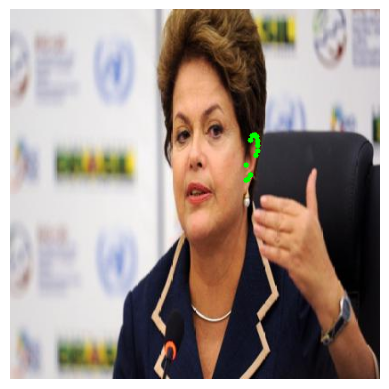

Traitement de l'image 2: /kaggle/input/ear-detection-v2-dataset/test/0100_png.rf.145673e69650fcf61745c44f753f7a87.jpg

image 1/1 /kaggle/input/ear-detection-v2-dataset/test/0100_png.rf.145673e69650fcf61745c44f753f7a87.jpg: 640x640 1 ear, 905.5ms
Speed: 2.9ms preprocess, 905.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step


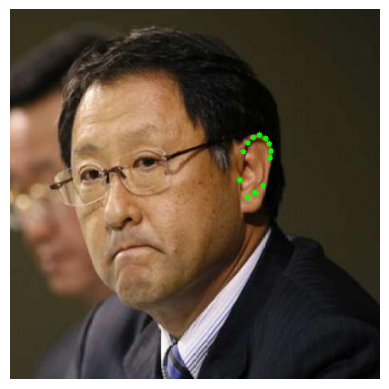

Traitement de l'image 3: /kaggle/input/ear-detection-v2-dataset/test/0297_png.rf.0b66455b2aa889be60f06446a6ca80a1.jpg

image 1/1 /kaggle/input/ear-detection-v2-dataset/test/0297_png.rf.0b66455b2aa889be60f06446a6ca80a1.jpg: 640x640 1 ear, 957.1ms
Speed: 3.7ms preprocess, 957.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step


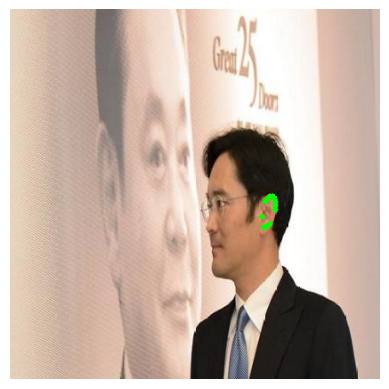

Traitement de l'image 4: /kaggle/input/ear-detection-v2-dataset/test/0224_png.rf.6381648d6678fdf7d4c9279c6b033d43.jpg

image 1/1 /kaggle/input/ear-detection-v2-dataset/test/0224_png.rf.6381648d6678fdf7d4c9279c6b033d43.jpg: 640x640 1 ear, 901.8ms
Speed: 13.0ms preprocess, 901.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step


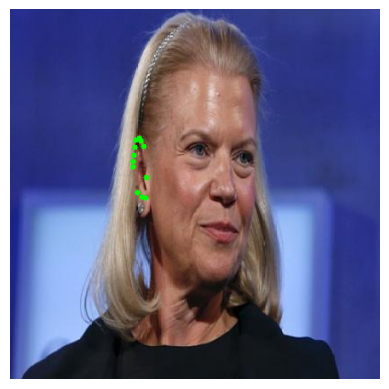

Traitement de l'image 5: /kaggle/input/ear-detection-v2-dataset/test/0079_png.rf.48328d71e40cbb59d8bcece876d00712.jpg

image 1/1 /kaggle/input/ear-detection-v2-dataset/test/0079_png.rf.48328d71e40cbb59d8bcece876d00712.jpg: 640x640 1 ear, 921.9ms
Speed: 3.0ms preprocess, 921.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step


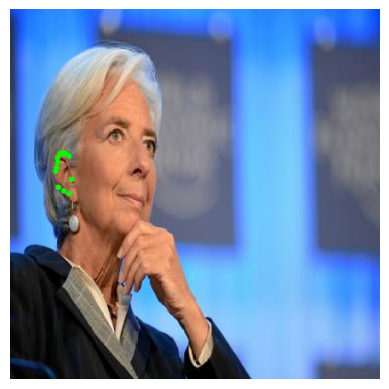

Traitement de l'image 6: /kaggle/input/ear-detection-v2-dataset/test/0005_png.rf.92e00517f6f0678906994e59eefa2b3d.jpg

image 1/1 /kaggle/input/ear-detection-v2-dataset/test/0005_png.rf.92e00517f6f0678906994e59eefa2b3d.jpg: 640x640 1 ear, 882.7ms
Speed: 3.1ms preprocess, 882.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


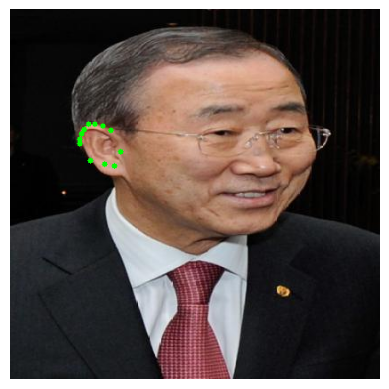

Traitement de l'image 7: /kaggle/input/ear-detection-v2-dataset/test/0051_png.rf.bdac5b8c6c99a12c71eb605848c20139.jpg

image 1/1 /kaggle/input/ear-detection-v2-dataset/test/0051_png.rf.bdac5b8c6c99a12c71eb605848c20139.jpg: 640x640 1 ear, 878.6ms
Speed: 3.0ms preprocess, 878.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step


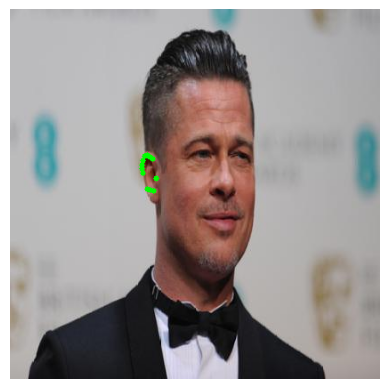

Traitement de l'image 8: /kaggle/input/ear-detection-v2-dataset/test/0221_png.rf.fd34f8cce63980f05c008bfcd2bd0396.jpg

image 1/1 /kaggle/input/ear-detection-v2-dataset/test/0221_png.rf.fd34f8cce63980f05c008bfcd2bd0396.jpg: 640x640 2 ears, 883.3ms
Speed: 2.9ms preprocess, 883.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step


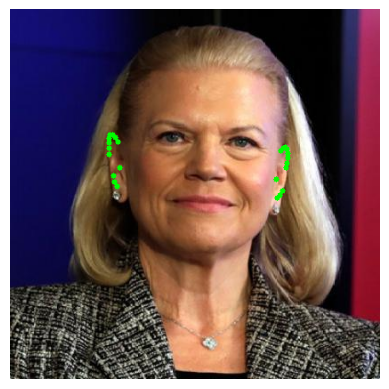

Traitement de l'image 9: /kaggle/input/ear-detection-v2-dataset/test/0249_png.rf.a929e931ed882c17490756029f6bf97d.jpg

image 1/1 /kaggle/input/ear-detection-v2-dataset/test/0249_png.rf.a929e931ed882c17490756029f6bf97d.jpg: 640x640 1 ear, 902.4ms
Speed: 3.0ms preprocess, 902.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step


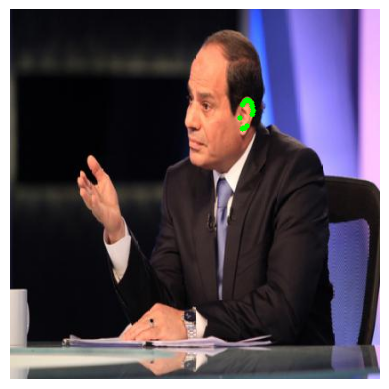

Traitement de l'image 10: /kaggle/input/ear-detection-v2-dataset/test/0277_png.rf.627ea5928d96a5bfa097014ec527ba30.jpg

image 1/1 /kaggle/input/ear-detection-v2-dataset/test/0277_png.rf.627ea5928d96a5bfa097014ec527ba30.jpg: 640x640 1 ear, 891.0ms
Speed: 3.2ms preprocess, 891.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step


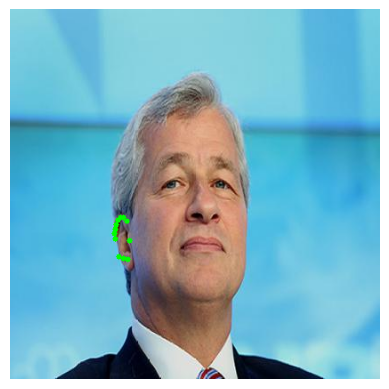

Traitement de l'image 11: /kaggle/input/ear-detection-v2-dataset/test/0026_png.rf.10a755ccf26f0c7fa57b8b96ef54b56b.jpg

image 1/1 /kaggle/input/ear-detection-v2-dataset/test/0026_png.rf.10a755ccf26f0c7fa57b8b96ef54b56b.jpg: 640x640 1 ear, 864.9ms
Speed: 3.1ms preprocess, 864.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


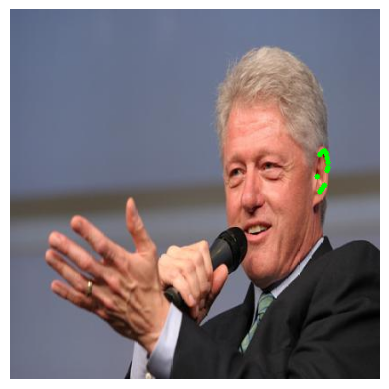

Traitement de l'image 12: /kaggle/input/ear-detection-v2-dataset/test/0098_png.rf.12fdcd962724e809ebe9b903d8a5677a.jpg

image 1/1 /kaggle/input/ear-detection-v2-dataset/test/0098_png.rf.12fdcd962724e809ebe9b903d8a5677a.jpg: 640x640 1 ear, 899.0ms
Speed: 15.9ms preprocess, 899.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step


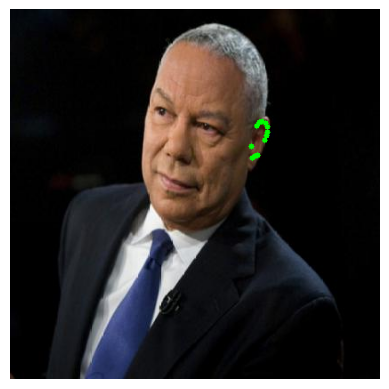

Traitement de l'image 13: /kaggle/input/ear-detection-v2-dataset/test/0066_png.rf.b799ada63b735f7ef98e3a240c43eb19.jpg

image 1/1 /kaggle/input/ear-detection-v2-dataset/test/0066_png.rf.b799ada63b735f7ef98e3a240c43eb19.jpg: 640x640 1 ear, 868.3ms
Speed: 4.6ms preprocess, 868.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step


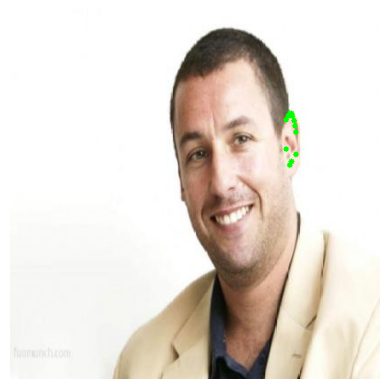

Traitement de l'image 14: /kaggle/input/ear-detection-v2-dataset/test/0183_png.rf.10a6d65130d37f17caec181bcd6d8d3d.jpg

image 1/1 /kaggle/input/ear-detection-v2-dataset/test/0183_png.rf.10a6d65130d37f17caec181bcd6d8d3d.jpg: 640x640 1 ear, 877.7ms
Speed: 10.7ms preprocess, 877.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step


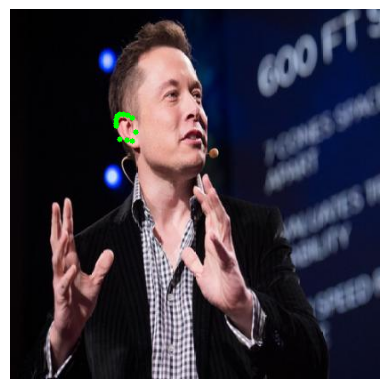

Traitement de l'image 15: /kaggle/input/ear-detection-v2-dataset/test/0260_png.rf.bc5b026f6000179308f6d6f9a06cfffc.jpg

image 1/1 /kaggle/input/ear-detection-v2-dataset/test/0260_png.rf.bc5b026f6000179308f6d6f9a06cfffc.jpg: 640x640 1 ear, 924.6ms
Speed: 2.9ms preprocess, 924.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step


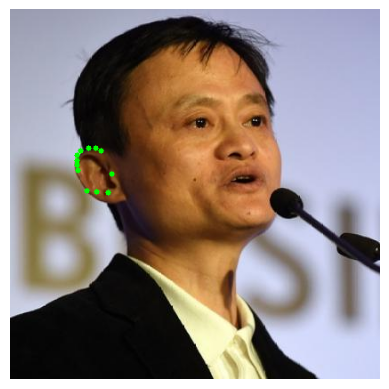

Traitement de l'image 16: /kaggle/input/ear-detection-v2-dataset/test/0072_png.rf.4fcee2e00a87db666cfac343f50c444e.jpg

image 1/1 /kaggle/input/ear-detection-v2-dataset/test/0072_png.rf.4fcee2e00a87db666cfac343f50c444e.jpg: 640x640 1 ear, 879.8ms
Speed: 2.9ms preprocess, 879.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step


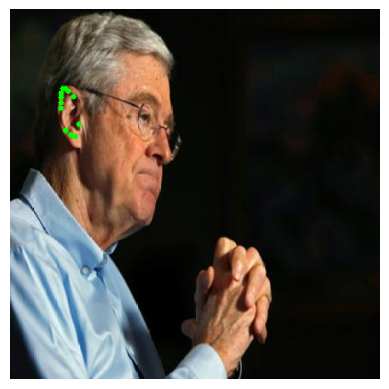

Traitement de l'image 17: /kaggle/input/ear-detection-v2-dataset/test/0225_png.rf.03c162e6600e5104b6cb993be99d7bdb.jpg

image 1/1 /kaggle/input/ear-detection-v2-dataset/test/0225_png.rf.03c162e6600e5104b6cb993be99d7bdb.jpg: 640x640 2 ears, 849.2ms
Speed: 3.1ms preprocess, 849.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step


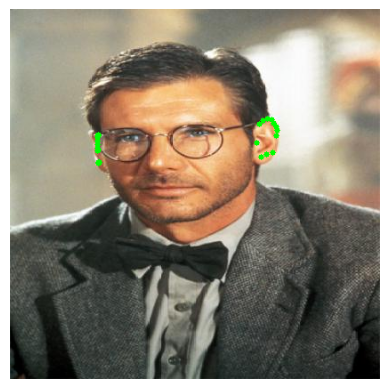

Traitement de l'image 18: /kaggle/input/ear-detection-v2-dataset/test/0256_png.rf.4dcc45342e6e57c115b19ecd30a4a6f8.jpg

image 1/1 /kaggle/input/ear-detection-v2-dataset/test/0256_png.rf.4dcc45342e6e57c115b19ecd30a4a6f8.jpg: 640x640 1 ear, 866.5ms
Speed: 3.1ms preprocess, 866.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


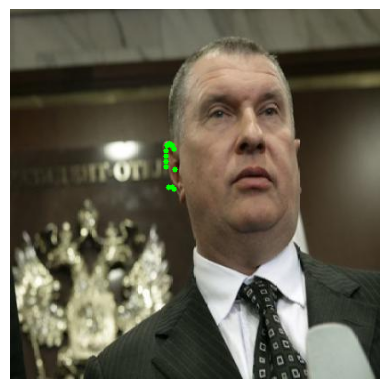

Traitement de l'image 19: /kaggle/input/ear-detection-v2-dataset/test/0132_png.rf.3aa40d11654569372b0027824b66922d.jpg

image 1/1 /kaggle/input/ear-detection-v2-dataset/test/0132_png.rf.3aa40d11654569372b0027824b66922d.jpg: 640x640 3 ears, 858.2ms
Speed: 2.9ms preprocess, 858.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step


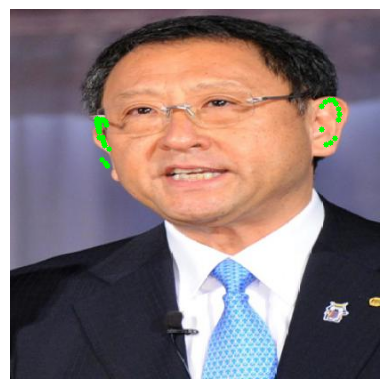

Traitement de l'image 20: /kaggle/input/ear-detection-v2-dataset/test/0227_png.rf.6b9e511d3f8dc12ec48115ece8ba6794.jpg

image 1/1 /kaggle/input/ear-detection-v2-dataset/test/0227_png.rf.6b9e511d3f8dc12ec48115ece8ba6794.jpg: 640x640 1 ear, 898.7ms
Speed: 2.9ms preprocess, 898.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step


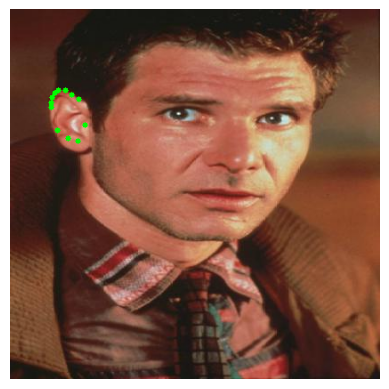

Traitement de l'image 21: /kaggle/input/ear-detection-v2-dataset/test/0101_png.rf.d7445e20c64ad3c530a35da2170fd9de.jpg

image 1/1 /kaggle/input/ear-detection-v2-dataset/test/0101_png.rf.d7445e20c64ad3c530a35da2170fd9de.jpg: 640x640 1 ear, 880.1ms
Speed: 3.2ms preprocess, 880.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step


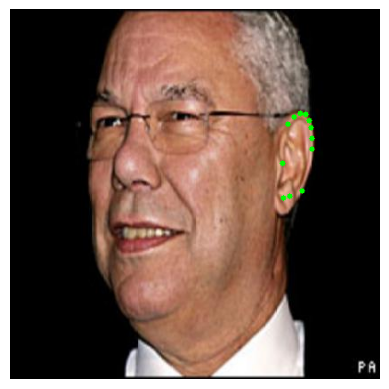

Traitement de l'image 22: /kaggle/input/ear-detection-v2-dataset/test/0173_png.rf.be0297687a3aa1ec1be98f89fbd43a55.jpg

image 1/1 /kaggle/input/ear-detection-v2-dataset/test/0173_png.rf.be0297687a3aa1ec1be98f89fbd43a55.jpg: 640x640 1 ear, 865.0ms
Speed: 3.0ms preprocess, 865.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step


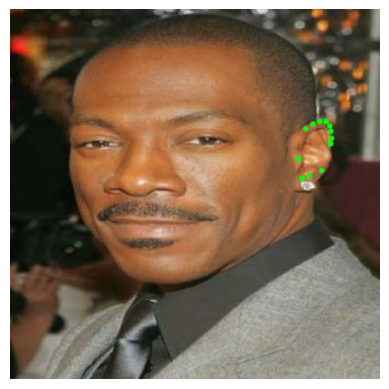

Traitement de l'image 23: /kaggle/input/ear-detection-v2-dataset/test/0240_png.rf.d67f77295ccd0f0eb4ab1f1731cc698f.jpg

image 1/1 /kaggle/input/ear-detection-v2-dataset/test/0240_png.rf.d67f77295ccd0f0eb4ab1f1731cc698f.jpg: 640x640 1 ear, 860.0ms
Speed: 2.9ms preprocess, 860.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step


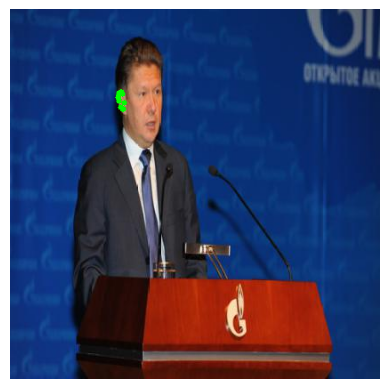

Traitement de l'image 24: /kaggle/input/ear-detection-v2-dataset/test/0067_png.rf.882356ecbb6a91951ca844b4cef7e165.jpg

image 1/1 /kaggle/input/ear-detection-v2-dataset/test/0067_png.rf.882356ecbb6a91951ca844b4cef7e165.jpg: 640x640 1 ear, 845.8ms
Speed: 2.9ms preprocess, 845.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step


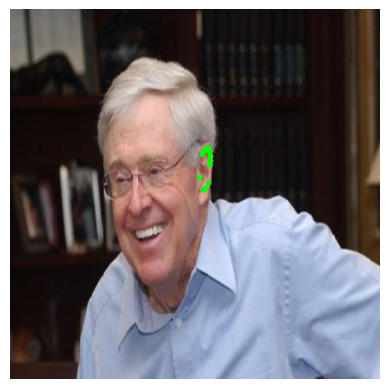

Traitement de l'image 25: /kaggle/input/ear-detection-v2-dataset/test/0107_png.rf.705d103cd515333f0cd0a3d211cf35da.jpg

image 1/1 /kaggle/input/ear-detection-v2-dataset/test/0107_png.rf.705d103cd515333f0cd0a3d211cf35da.jpg: 640x640 1 ear, 857.8ms
Speed: 2.8ms preprocess, 857.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step


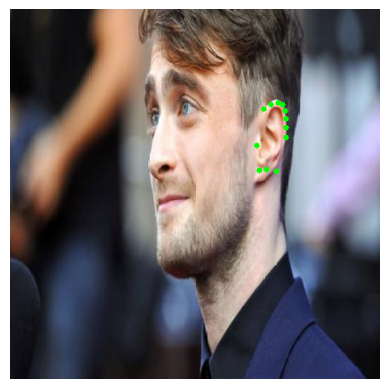

Traitement de l'image 26: /kaggle/input/ear-detection-v2-dataset/test/0166_png.rf.1e73e8a6ff85b77fdf14afe788cab72e.jpg

image 1/1 /kaggle/input/ear-detection-v2-dataset/test/0166_png.rf.1e73e8a6ff85b77fdf14afe788cab72e.jpg: 640x640 2 ears, 855.2ms
Speed: 2.9ms preprocess, 855.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step


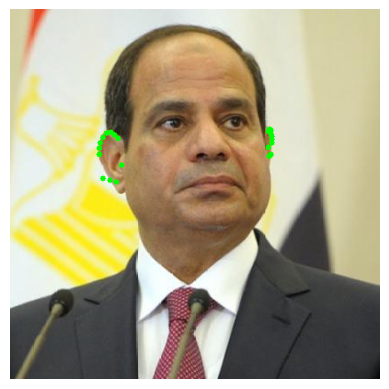

Traitement de l'image 27: /kaggle/input/ear-detection-v2-dataset/test/0191_png.rf.f1fc7d70c5c1ff13c806ac24a8a16b95.jpg

image 1/1 /kaggle/input/ear-detection-v2-dataset/test/0191_png.rf.f1fc7d70c5c1ff13c806ac24a8a16b95.jpg: 640x640 1 ear, 877.1ms
Speed: 3.1ms preprocess, 877.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step


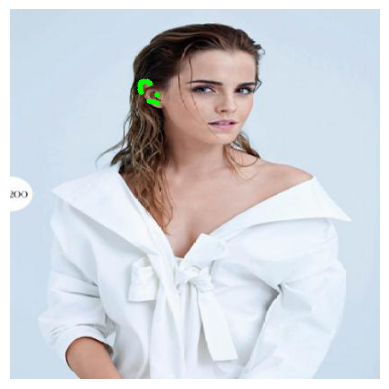

Traitement de l'image 1: /kaggle/input/ear-detection-v2-dataset/test/0130_png.rf.5ac90ebfe93070a601372670f606e751.jpg

image 1/1 /kaggle/input/ear-detection-v2-dataset/test/0130_png.rf.5ac90ebfe93070a601372670f606e751.jpg: 640x640 1 ear, 845.7ms
Speed: 4.0ms preprocess, 845.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step
Image sauvegardée : output_results/image_1.jpg
Traitement de l'image 2: /kaggle/input/ear-detection-v2-dataset/test/0100_png.rf.145673e69650fcf61745c44f753f7a87.jpg

image 1/1 /kaggle/input/ear-detection-v2-dataset/test/0100_png.rf.145673e69650fcf61745c44f753f7a87.jpg: 640x640 1 ear, 852.4ms
Speed: 3.1ms preprocess, 852.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step
Image sauvegardée : output_results/image_2.jpg
Traitement de l'image 3: /kaggle/input/ear-detection-v2-dataset/test/0297_png.rf.0b66455b2aa889be60f06446a6ca80a1.jpg

image 1/1 /kaggle/inp

In [7]:
# Main function
def main():
    # Charger les modèles
    yolo_model_path = '/kaggle/input/yolov8_v2/pytorch/default/1/kaggle/working/runs/detect/ear_detection2/weights/best.pt'
    landmark_model_path = '/kaggle/input/landmarks_detection_model/tensorflow2/default/1/my_model.h5'

    
    yolo_model, landmark_model = load_models(yolo_model_path, landmark_model_path)

    # Liste des images à traiter
    test_images = glob('/kaggle/input/ear-detection-v2-dataset/test/*.jpg')

    # Pipeline : Détection et prédiction des landmarks
    detect_and_predict_landmarks(yolo_model, landmark_model, test_images, conf=0.1)

    # Sauvegarde des résultats
    output_dir = 'output_results'
    save_results(yolo_model, landmark_model, test_images, output_dir, conf=0.1)

# Lancer le programme principal
if __name__ == "__main__":
    main()